<a href="https://colab.research.google.com/github/anatoliy-gorbenko/TM-learning-visualisation/blob/main/TM_learning_visualisation_ISTM_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM Learning Visualisation on MNIST dataset
A demo of how TM learns handwritten digit patterns and accumulates knowledge in conjunctive clauses

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib
import matplotlib.pylab as plt
import pylab as pl
import pandas as pd
from IPython import display
%matplotlib inline

## Installing pyTsetlinMachineParallel

In [ ]:
!pip install pyTsetlinMachineParallel
!export OMP_NUM_THREADS=10

## Preparing the dataset
The original MNIST of 28x28 pixel digit images is converted to 14x14 images for better visualisation

In [ ]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_val, Y_val) = mnist.load_data()

2023-08-22 13:42:02.029547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
X_train_14 = []
for i in range (0, X_train.shape[0]):
  grayImage = cv2.cvtColor(X_train[i], cv2.COLOR_GRAY2BGR)
  grayImage = cv2.resize(grayImage, (14,14))
  X_train_14.append(grayImage[:,:,0])
X_train_14 = np.array(X_train_14)
X_val_14 = []
for i in range (0, X_val.shape[0]):
  grayImage = cv2.cvtColor(X_val[i], cv2.COLOR_GRAY2BGR)
  grayImage = cv2.resize(grayImage, (14,14))
  X_val_14.append(grayImage[:,:,0])
X_val_14 = np.array(X_val_14)

In [ ]:
# Data booleanization
X_train_14 = np.where(X_train_14 > 75, 1, 0)
X_val_14 = np.where(X_val_14 > 75, 1, 0)

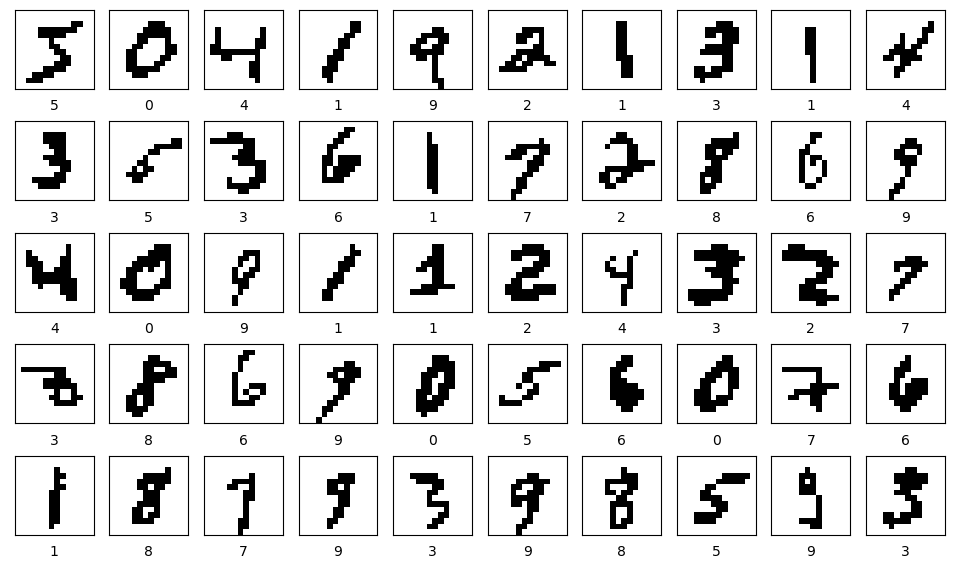

In [ ]:
# Show booleanized data
plt.figure(figsize=(12,7))
for i in range(0,50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_14[i], cmap=plt.cm.binary)
    plt.xlabel(Y_train[i])

In [ ]:
# Input data flattening
X_train_14 = X_train_14.reshape(X_train_14.shape[0], 14*14)
X_val_14 = X_val_14.reshape(X_val_14.shape[0], 14*14)

Y_train = Y_train.flatten()
Y_val = Y_val.flatten()

## Showing a Heatmap of Handwritten Digit Templates

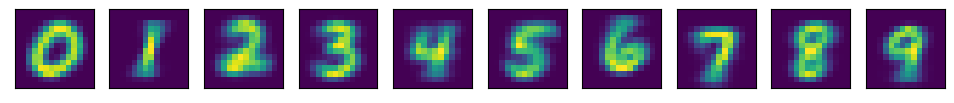

In [ ]:
# Display digit templates/heatmap
d_mask_14 = np.zeros((10,14*14), dtype=np.uint32)
for i in range(X_val_14.shape[0]):
  d_mask_14[Y_val[i]] = d_mask_14[Y_val[i]] + X_val_14[i,:]
for i in range(10):
  d_mask_14[i] = d_mask_14[i] / max(d_mask_14[i]) * 255
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(d_mask_14[i].reshape(14, 14))

## Displaying live clause training (epoch by epoch)
Digit class: 0; polarity: 0 (i.e. clauses voting FOR the class)

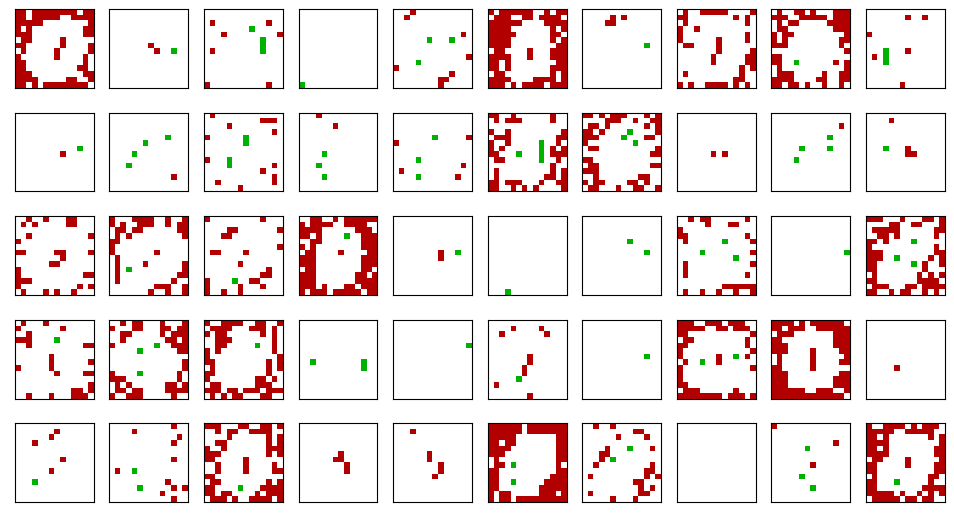

In [ ]:
# Display live clause training epoch by epoch
from pyTsetlinMachineParallel.tm import MultiClassTsetlinMachine
#from PyTsetlinMachineCUDA.tm import MultiClassTsetlinMachine
C = 100
T = 10
s = 5
ep = 1000
tm = MultiClassTsetlinMachine(C, T, s)
plt.figure(figsize=(12,6.5))
plt.ion()
tm.fit(X_train_14, Y_train, epochs=0)
for k in range(100):
  polarity = 0
  y = 0
  clause_lable = []
  l = np.zeros((tm.number_of_clauses//2, tm.number_of_features//2), dtype=np.uint32)
  l_0 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  l_1 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  for i in range(polarity, tm.number_of_clauses, 2):
    for j in range(tm.number_of_features):
      if tm.ta_action(y, i, j) == 1: # symbol's class
        if j < tm.number_of_features//2:
          l[i//2, j] = 1
          l_1[j] += 1
        else:
          l[i//2, j-tm.number_of_features//2] = 2
          l_0[j-tm.number_of_features//2] += 1

  palette = np.array([[  255,   255,   255],   # white
                    [  0, 178,   0],   # dark green
                    [  178, 0,  0]])   # dark red

  for i in range(0,tm.number_of_clauses//2):
    plt.subplot(tm.number_of_clauses//20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if clause_lable != []:
      plt.xlabel(clause_lable[i])
    RGB = palette[l[i].reshape(int(np.sqrt(tm.number_of_features//2)),int(np.sqrt(tm.number_of_features//2)))]
    plt.imshow(RGB)
  display.display(pl.gcf())
  display.clear_output(wait=True)

  tm.fit(X_train_14, Y_train, epochs=1, incremental=True)

## Functions to visualize clause states and their aggregation

In [ ]:
def tm_clause_display(tm, polarity = 0, y = 0, clause_lable = []):
  l = np.zeros((tm.number_of_clauses//2, tm.number_of_features//2), dtype=np.uint32)
  l_0 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  l_1 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
  for i in range(polarity, tm.number_of_clauses, 2):
    for j in range(tm.number_of_features):
      if tm.ta_action(y, i, j) == 1: # symbol's class
        if j < tm.number_of_features//2:
          l[i//2, j] = 1
          l_1[j] += 1
        else:
          l[i//2, j-tm.number_of_features//2] = 2
          l_0[j-tm.number_of_features//2] += 1

  palette = np.array([[  255,   255,   255],   # white
                    [  0, 204,   0],   # dark green
                    [  204, 0,  0]])   # dark red

  plt.figure(figsize=(12,6.5))
  for i in range(0,tm.number_of_clauses//2):
    plt.subplot(tm.number_of_clauses//20,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if clause_lable != []:
      plt.xlabel(clause_lable[i])

    RGB = palette[l[i].reshape(int(np.sqrt(tm.number_of_features//2)),int(np.sqrt(tm.number_of_features//2)))]
    plt.imshow(RGB)
    #plt.imshow(l[i].reshape(int(np.sqrt(tm.number_of_features//2)),int(np.sqrt(tm.number_of_features//2))), cmap=matplotlib.colormaps.get_cmap('Set1')) #jet

  l_0 = l_0 / max(l_0) * 255
  l_1 = l_1 / max(l_1) * 255
  plt.figure(figsize=(11.8, 6))
  plt.subplot(1,2,1)
  plt.imshow(l_0.reshape(14, 14), cmap=matplotlib.colormaps.get_cmap('OrRd')) #viridis  magma
  plt.subplot(1,2,2)
  plt.imshow(l_1.reshape(14, 14), cmap=matplotlib.colormaps.get_cmap('BuGn'))

In [ ]:
def tm_agg_clause_display(tm, polarity):

  plt.figure(figsize=(12,2.2))

  for y in range(0,tm.number_of_classes):
    l_0 = np.zeros((tm.number_of_features//2), dtype=np.uint32)
    l_1 = np.zeros((tm.number_of_features//2), dtype=np.uint32)

    for i in range(polarity, tm.number_of_clauses, 2):
      for j in range(tm.number_of_features):
        if tm.ta_action(y, i, j) == 1: # symbol's class
          if j < tm.number_of_features//2:
            l_1[j] += 1
          else:
            l_0[j-tm.number_of_features//2] += 1

    l_0 = l_0 / max(l_0) * 255
    l_1 = l_1 / max(l_1) * 255
    plt.subplot(2,10, y+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(l_1.reshape(14, 14), cmap=matplotlib.colormaps.get_cmap('BuGn'))
    plt.subplot(2,10,10 + y + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(l_0.reshape(14, 14), cmap=matplotlib.colormaps.get_cmap('OrRd'))

In [ ]:
def clause_output(x, x_class, tm):
  x_vector = np.ones((x.shape[0]), dtype=np.uint32)
  x_vector = np.concatenate((x, (x ^ x_vector)), axis=0)
  clause_out = []
  for i in range(0, tm.number_of_clauses, 1):
    out = 1
    for j in range(tm.number_of_features):
      if tm.ta_action(x_class, i, j) == 1 and x_vector[j] == 0:
        out = 0 #print(0)
        break
    clause_out.append(out)
  return np.array(clause_out, dtype=np.uint32)

In [ ]:
def clause_score_average(X, Y, tm):
  clause_score = np.zeros((tm.number_of_classes, 2, tm.number_of_clauses), dtype=float)
  #the second dimension is: 0 - True Positives (TP), 1 - True Negatives (TN)
  count_class = np.zeros((tm.number_of_classes), dtype=np.uint32)
  for i in tqdm(range(X.shape[0])):
    count_class[Y[i]] += 1
    for j in range(tm.number_of_classes):
      if j == Y[i]:
        clause_score[j, 0] += clause_output(X[i], j, tm)
      else:
        clause_score[j, 1] += clause_output(X[i], j, tm)
  for i in range(tm.number_of_classes):
    clause_score[i, 0] /= count_class[i]
    clause_score[i, 1] /= X.shape[0] - count_class[i]
  return clause_score

## Showing a hitmap of positive and negative clauses aggregated by class
Green pixels - {Xi}, Red pixels - {Not Xi}

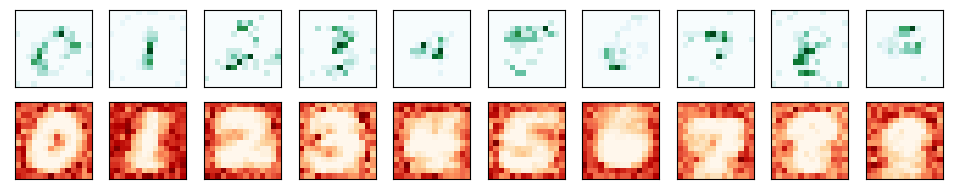

In [ ]:
# A hitmap of aggregated positive (i.e. voting FOR the class)clauses: green - Xi, red - not Xi
tm_agg_clause_display(tm, polarity=0)

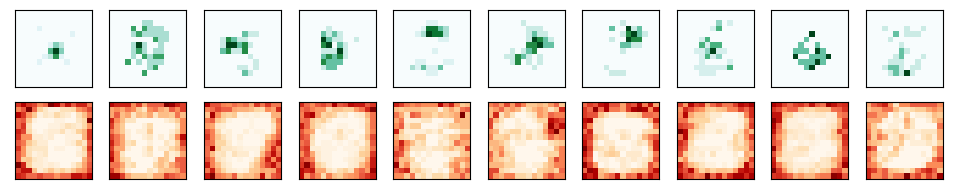

In [ ]:
# A hitmap of aggregated negative (i.e. voting AGAINST the class) clauses: green - Xi, red - not Xi
tm_agg_clause_display(tm, polarity=1)

## Showing clause states for a certain class
Set: polarity = {0, 1} - positive or negative clauses; y = {0..9} - class

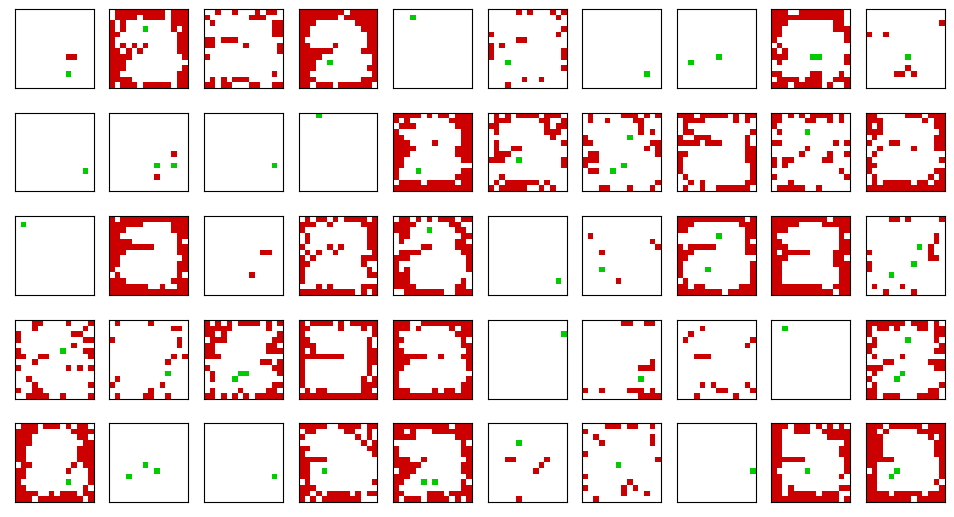

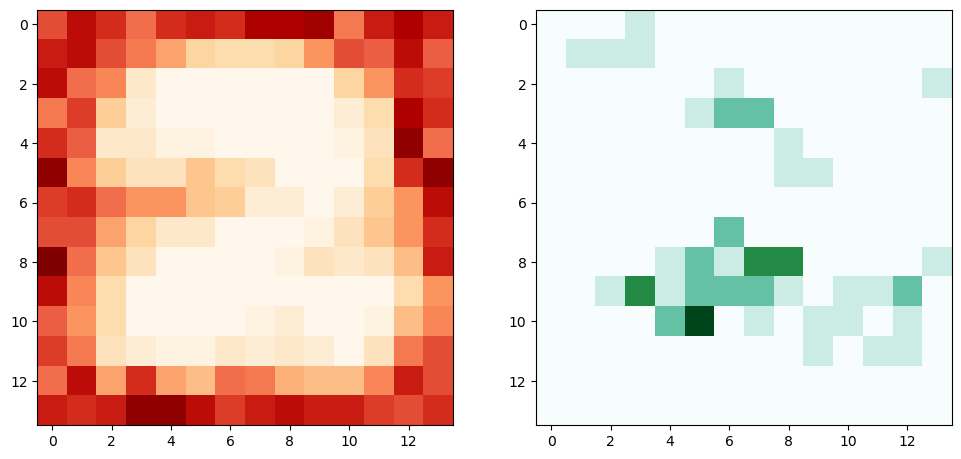

In [ ]:
tm_clause_display(tm, polarity = 0, y = 2)

## Estimating clauses accuracy (% of True Positives / False Positives)

In [ ]:
clause_score_av_train = clause_score_average(X_train_14[0:60000], Y_train[0:60000], tm)

100%|███████████████████████████████████████████████████████████████████████████| 60000/60000 [1:54:31<00:00,  8.73it/s]


## Displaying clauses and their accuracy (% of True Positives / False Positives)
Set: polarity = {0, 1} - positive or negative clauses; yclass = {0..9} - class

Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class= 0


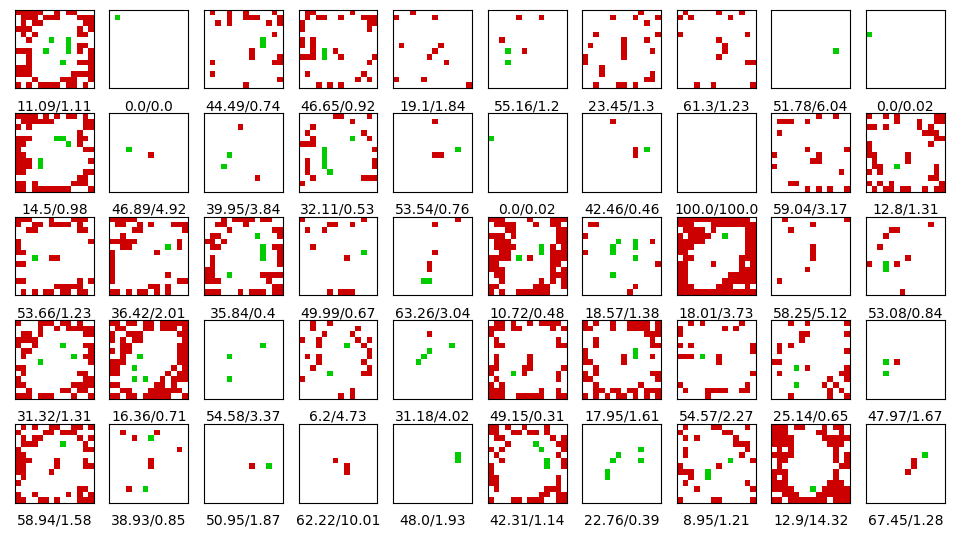

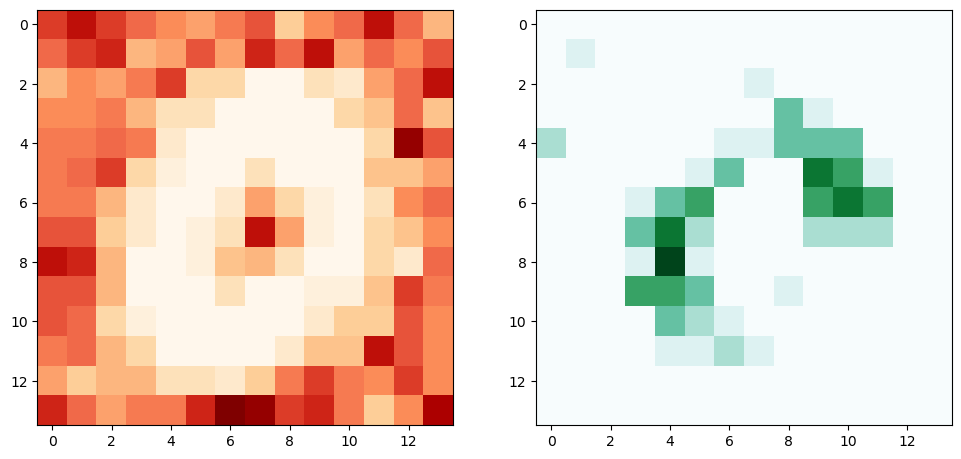

In [ ]:
# Display POSITIVE clauses with accuracy labels (True Positives / False Positives)
yclass = 0
polarity = 0
clause_label = []
print("Display POSITIVE clauses with accuracy labels (True Positives / False Positives): class=", yclass)
for i in range(tm.number_of_clauses//2):
  clause_label.append(str(round(clause_score_av_train[yclass, 0][polarity::2][i]*100, 2)) + '/' + str(round(clause_score_av_train[yclass, 1][polarity::2][i]*100, 2)))
tm_clause_display(tm, polarity, yclass, clause_label)

Display positive clauses with accuracy label (True Negative / False Negative): class= 0


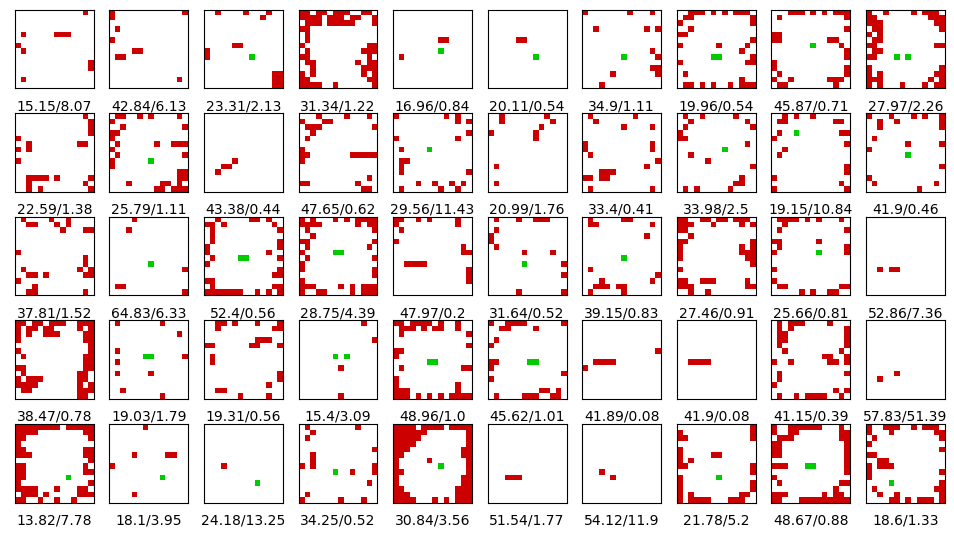

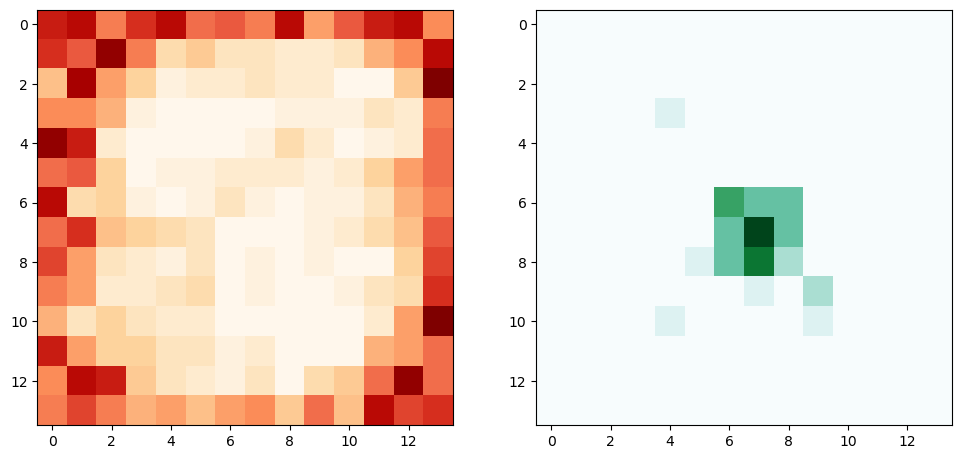

In [ ]:
# Display NEGATIVE clauses with accuracy (True Positives / False Positives)
yclass = 0
polarity = 1
clause_label = []
print("Display positive clauses with accuracy label (True Negative / False Negative): class=", yclass)
clause_label = []
for i in range(tm.number_of_clauses//2):
  clause_label.append(str(round((clause_score_av_train[yclass, 1][polarity::2][i])*100, 2)) + '/' + str(round((clause_score_av_train[yclass, 0][polarity::2][i])*100, 2)))
tm_clause_display(tm, polarity, yclass, clause_label)

## Estimating average clause votes (True positives and True negatives) per class

In [ ]:
#Class Sum: True Positive
class_sum = []
for i in range(tm.number_of_classes):
  vote_sum = 0
  for j in range(tm.number_of_clauses):
    if j % 2 == 0:
      vote_sum += clause_score_av_train[i, 0, j]
    else:
      vote_sum -= clause_score_av_train[i, 0, j]
  class_sum.append(vote_sum)
print("\n",class_sum)


 [16.71652878608813, 12.085286265203207, 11.84055052030883, 12.108302071440225, 13.484936665525508, 11.021029330381854, 15.942717134166946, 15.510454908220272, 9.730302512391045, 9.277693730038662]


In [ ]:
#Class Sum: True Negative
class_sum = []
for i in range(tm.number_of_classes):
  vote_sum = 0
  for j in range(tm.number_of_clauses):
    if j % 2 == 0:
      vote_sum += clause_score_av_train[i, 1, j]
    else:
      vote_sum -= clause_score_av_train[i, 1, j]
  class_sum.append(vote_sum)
print("\n",class_sum)


 [-14.862751262089247, -15.735814337752073, -13.501776396136338, -10.476804841374442, -11.745762398906905, -11.699994503380424, -13.52523945120373, -12.01129617567693, -9.983803948364697, -12.097852028639617]
